## Prepare data

### Only consider remove outliers

Read all the data. Apply simple outlier removal by validity range.

In [8]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


base_dictionary = '../../projects/maintenance_industry_4_2024/dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

## Define experiment supporting function

Here we define two supporting functions:
- run_one_motor_detection: runs one motor detection experiment
- run_all_motors: runs experiments on all the six motors.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from utility import run_cross_val


def run_one_motor_detection(motor_idx, df_data, mdl, window_size=0, single_run_result=True, mdl_type='clf'):
    ''' Train and test the fault detection model for one motor. '''
    # Get the name of the response variable.
    y_name = f'data_motor_{motor_idx}_label'

    # Seperate features and the response variable.
    # Remove the irrelavent features.
    df_x = df_data.drop(columns=['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label',
                                    'data_motor_4_label', 'data_motor_5_label','data_motor_6_label'])
    # Get y.
    y = df_data.loc[:, y_name]

    print(f'Model for predicting the label of motor {motor_idx}:')
    # Run cross validation.
    df_perf = run_cross_val(mdl, df_x, y, window_size=window_size, single_run_result=single_run_result, mdl_type=mdl_type)
    # Print the mean performance.
    print(df_perf.mean())
    print('\n')

    return df_perf


def run_all_motors(df_data, mdl, window_size=0, single_run_result=True, mdl_type='clf'):
    all_results = []
    # Loop over all the six motors.
    for i in range(1, 7):
        df_perf = run_one_motor_detection(i, df_data, mdl, window_size=window_size, single_run_result=single_run_result, mdl_type=mdl_type)

        all_results.append(df_perf)

    return all_results

## Logistic regression

### Dataset

In this notbook, we run an experiment on motor 6. We pick 5 datasets where four contains failure labels and the one does not.

In [10]:
# We pick five tests with label 1.
df_data = df_data[df_data['test_condition'].isin(['20240325_155003', '20240425_093699', '20240425_094425', '20240426_140055', '20240426_141190'])]

### Window size = 0

Model for predicting the label of motor 6:

 New cv run:

Training performance, accuracy is: 0.7920439844760673
Training performance, precision is: 0.2667509481668774
Training performance, recall: 0.7700729927007299
Training performance, F1: 0.39624413145539905


Prediction performance, accuracy is: 0.9069452796151534
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


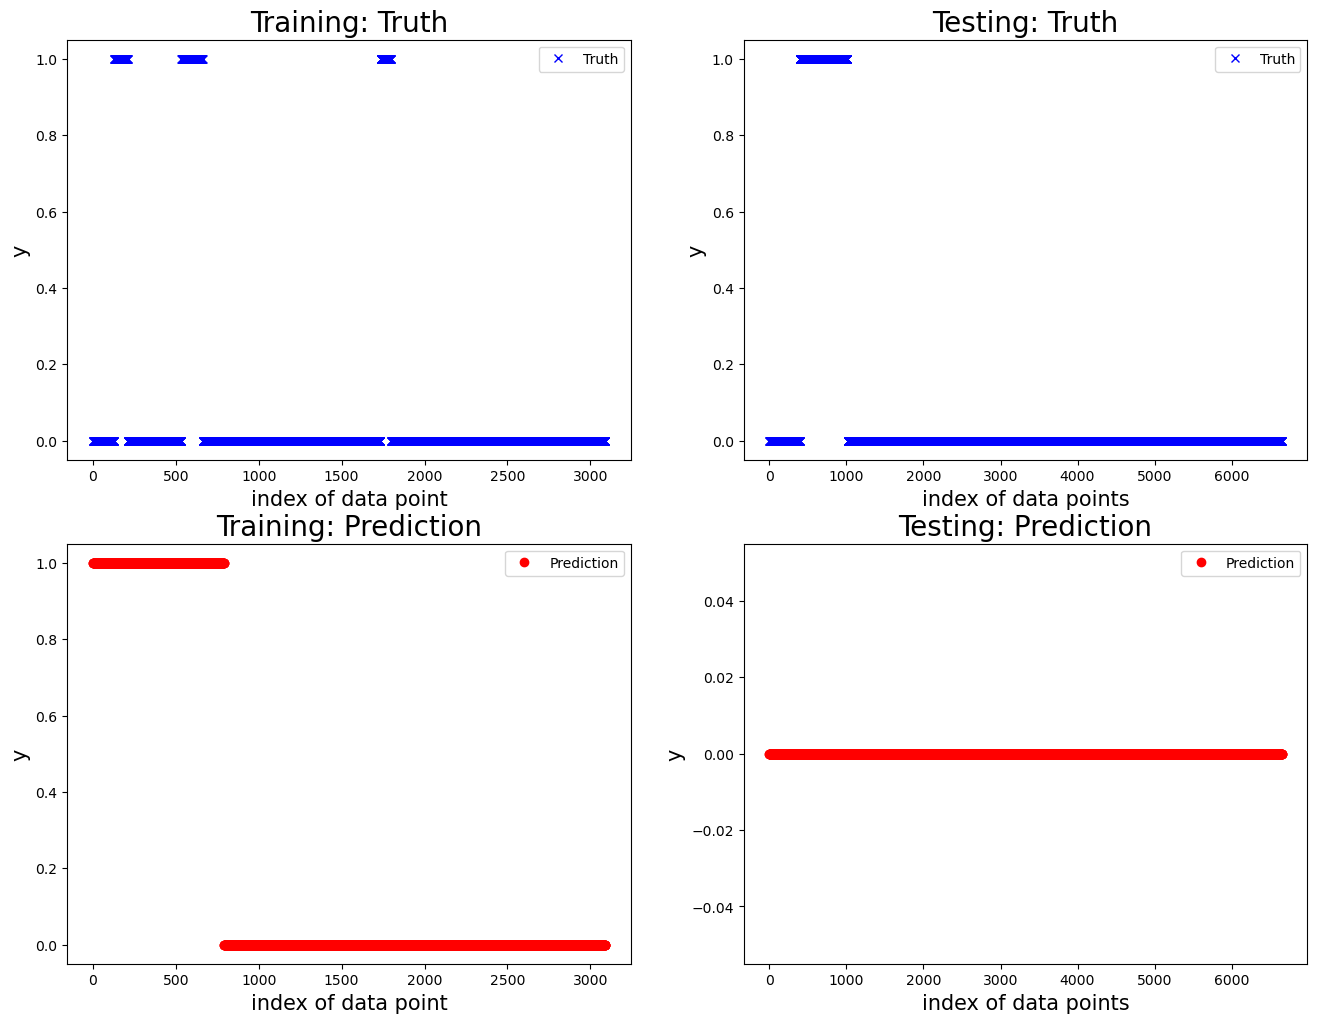


 New cv run:

Training performance, accuracy is: 0.84053400609692
Training performance, precision is: 0.3393994540491356
Training performance, recall: 0.9198520345252774
Training performance, F1: 0.4958457959454969


Prediction performance, accuracy is: 0.354978354978355
Prediction performance, precision is: 0.354978354978355
Prediction performance, recall is：1.0
Prediction performance, F1 is：0.5239616613418531


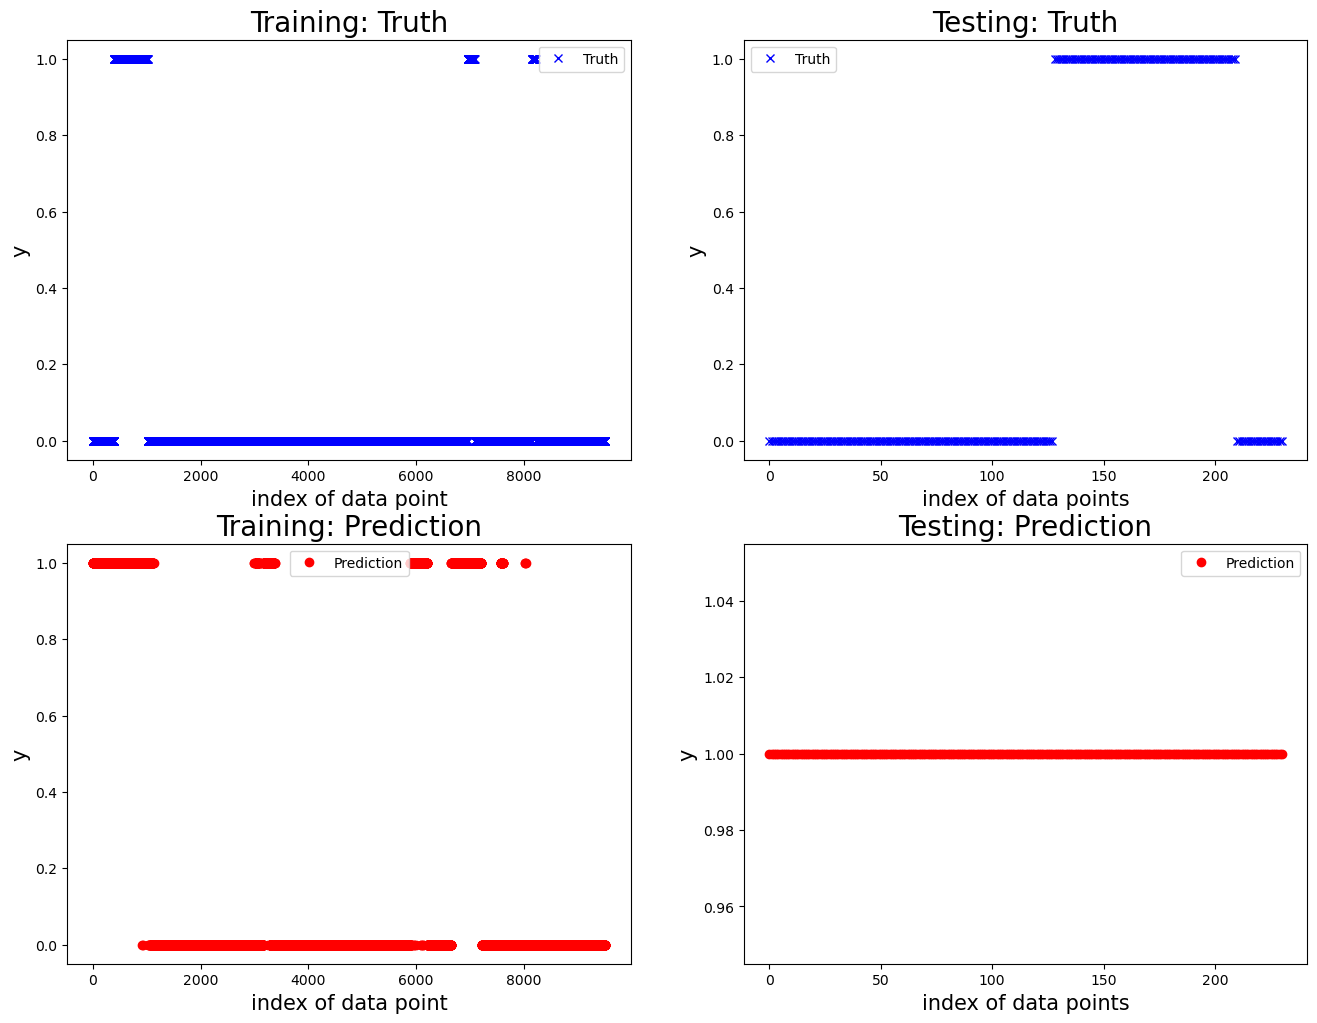


 New cv run:

Training performance, accuracy is: 0.9710365853658537
Training performance, precision is: 0.7572314049586777
Training performance, recall: 0.9594240837696335
Training performance, F1: 0.8464203233256351


Prediction performance, accuracy is: 0.8607142857142858
Prediction performance, precision is: 1.0
Prediction performance, recall is：0.3953488372093023
Prediction performance, F1 is：0.5666666666666667


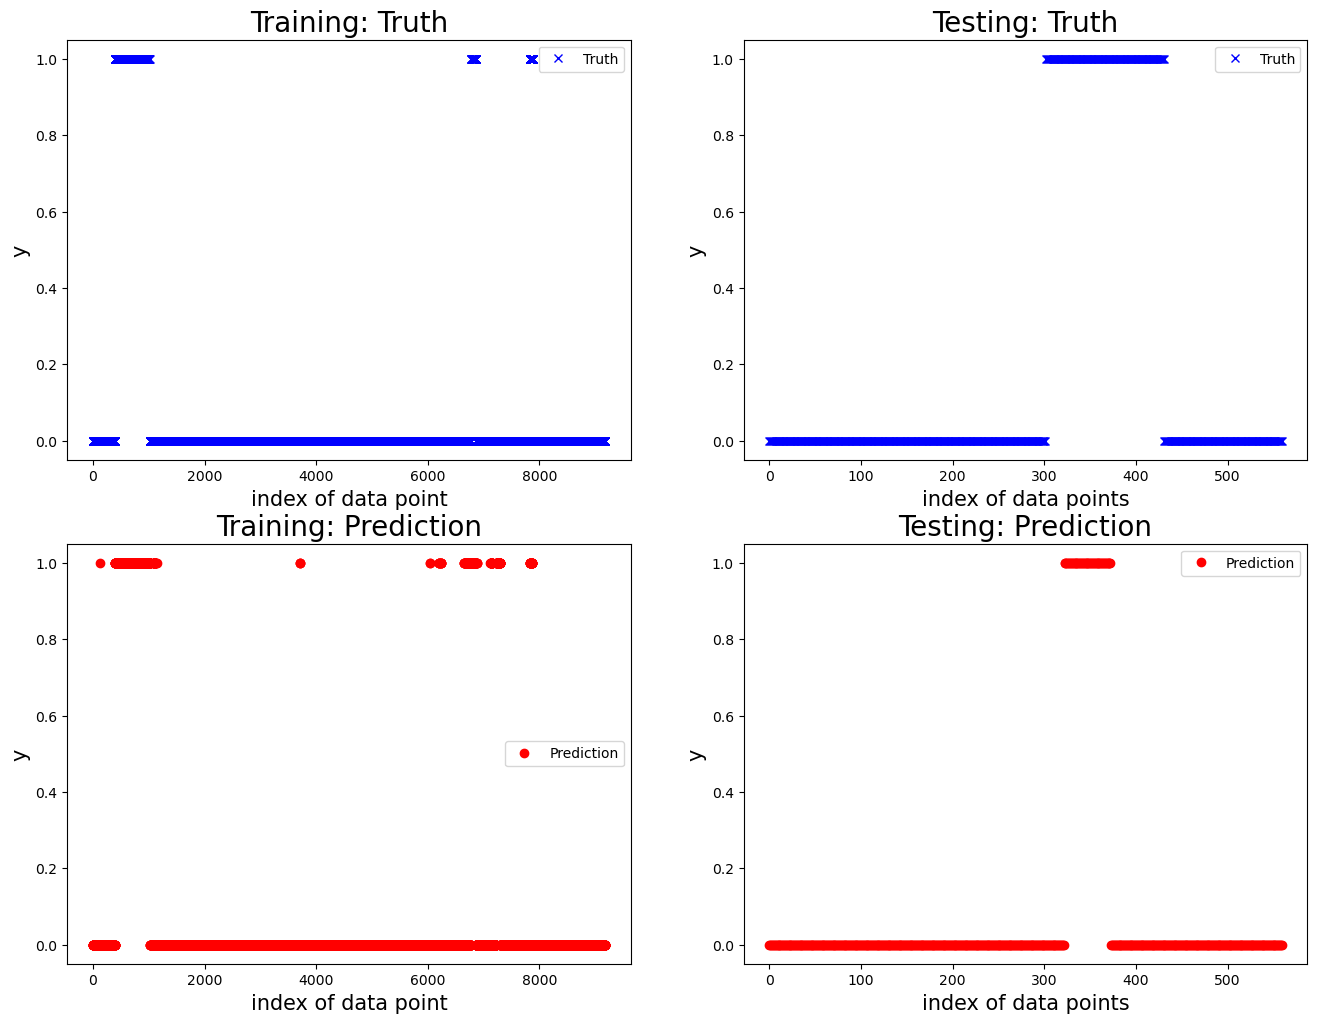


 New cv run:

Training performance, accuracy is: 0.8444827586206897
Training performance, precision is: 0.3797701149425287
Training performance, recall: 0.9951807228915662
Training performance, F1: 0.5497504159733777


Prediction performance, accuracy is: 0.9022988505747126
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


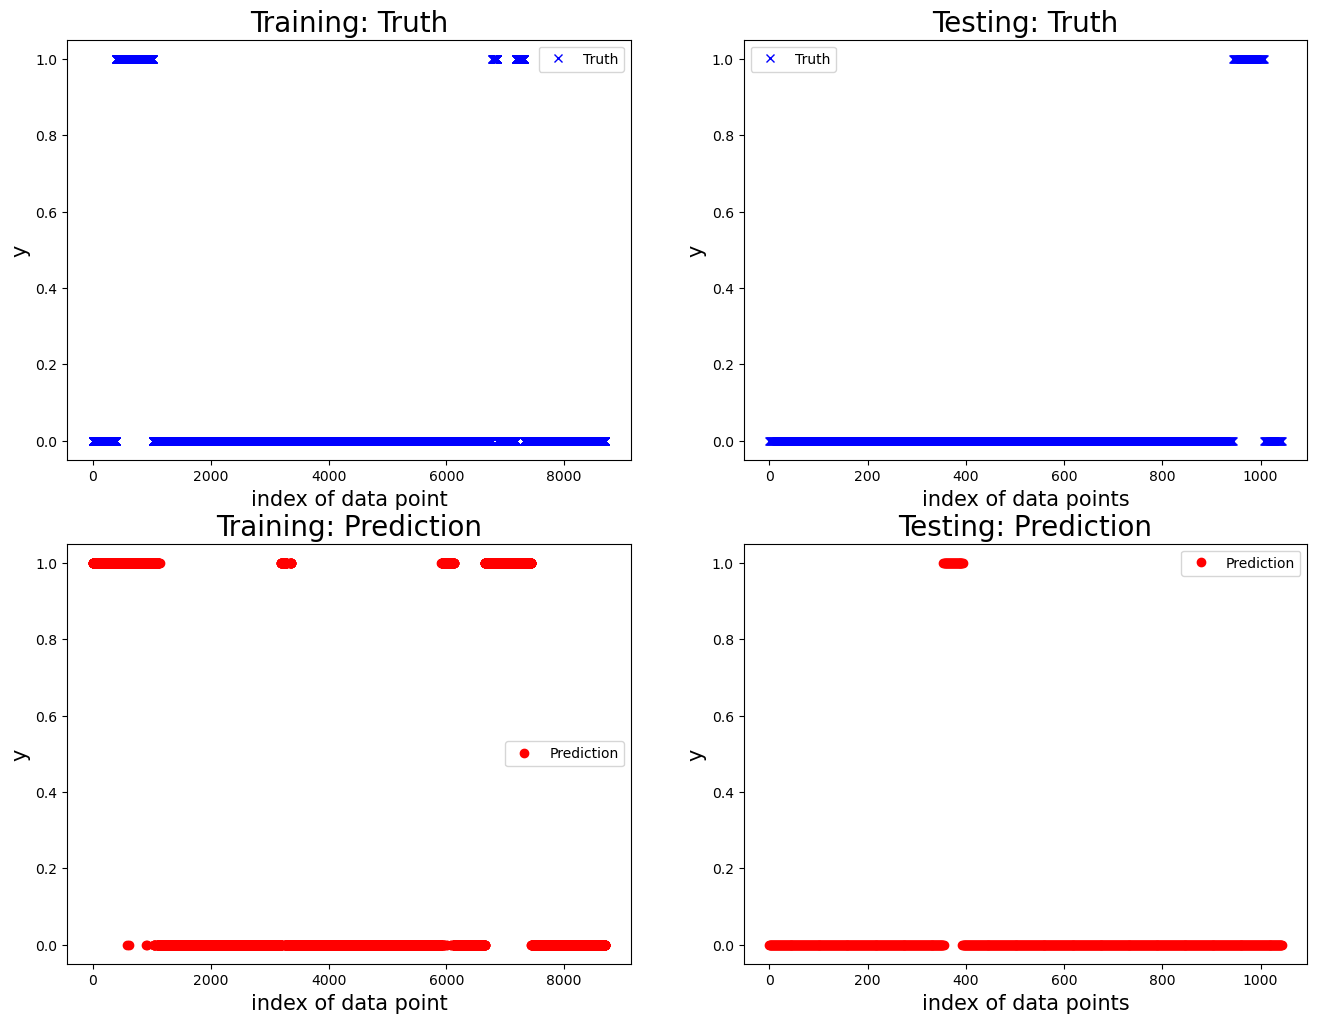


 New cv run:

Training performance, accuracy is: 0.9320136679627666
Training performance, precision is: 0.618440779610195
Training performance, recall: 0.9238521836506159
Training performance, F1: 0.740907049842838


Prediction performance, accuracy is: 1.0
Prediction performance, precision is: 1.0
Prediction performance, recall is：1.0
Prediction performance, F1 is：1.0


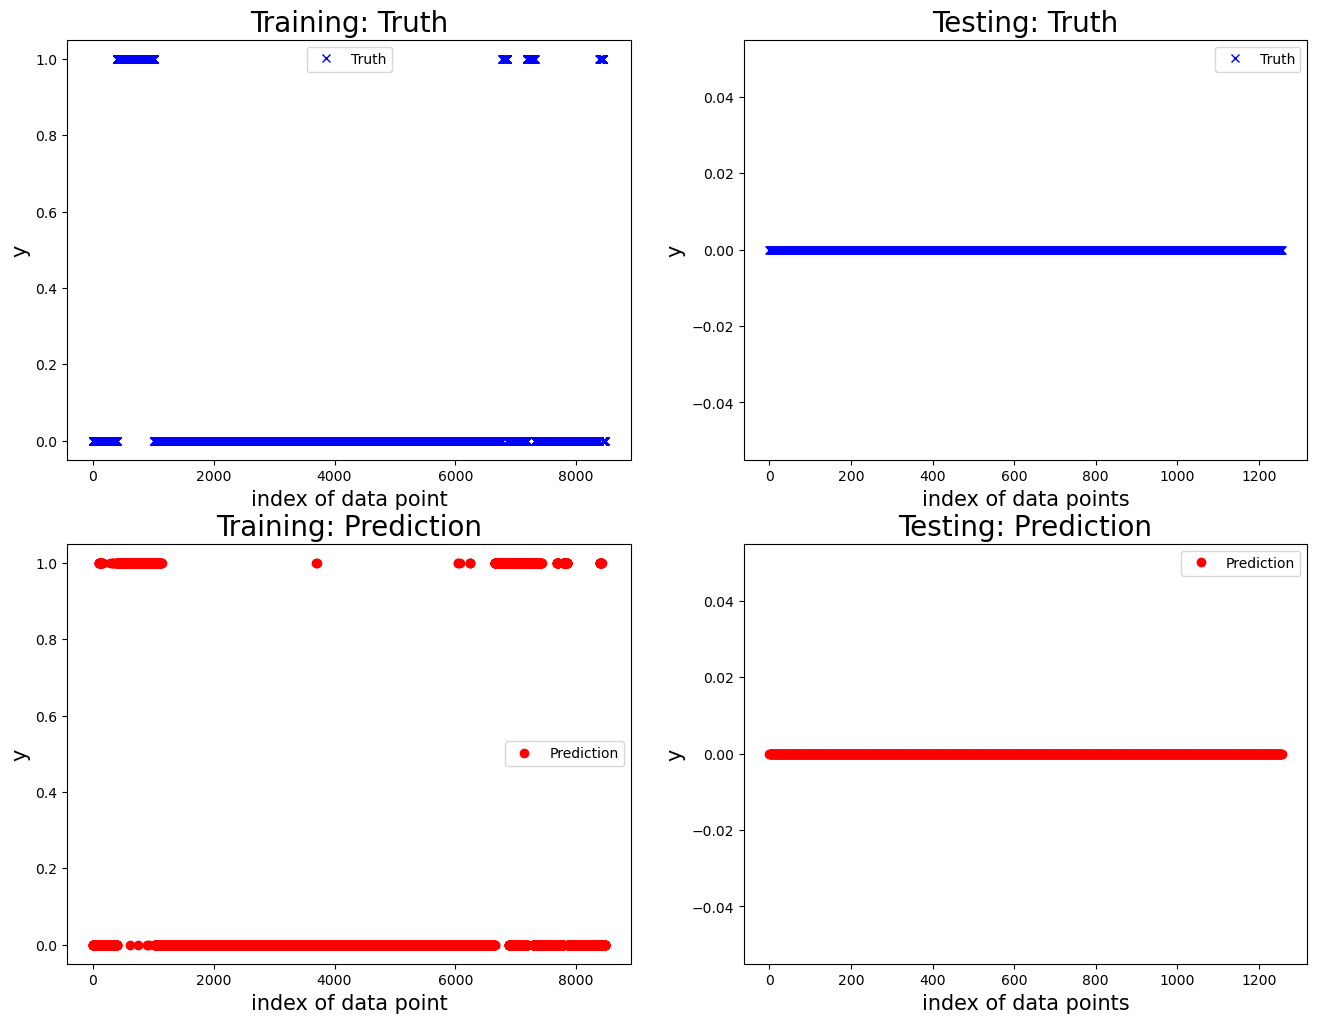

Accuracy     0.804987
Precision    0.470996
Recall       0.479070
F1 score     0.418126
dtype: float64




In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced'))    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# all_results = run_all_motors(df_data, grid_search, window_size=0, single_run_result=False, mdl_type='clf')
all_results = run_one_motor_detection(6, df_data, grid_search, window_size=0, single_run_result=True, mdl_type='clf')

### window size = 5

Model for predicting the label of motor 6:

 New cv run:

Training performance, accuracy is: 0.7939453125
Training performance, precision is: 0.2701664532650448
Training performance, recall: 0.7700729927007299
Training performance, F1: 0.39999999999999997


Prediction performance, accuracy is: 0.9068752820821423
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


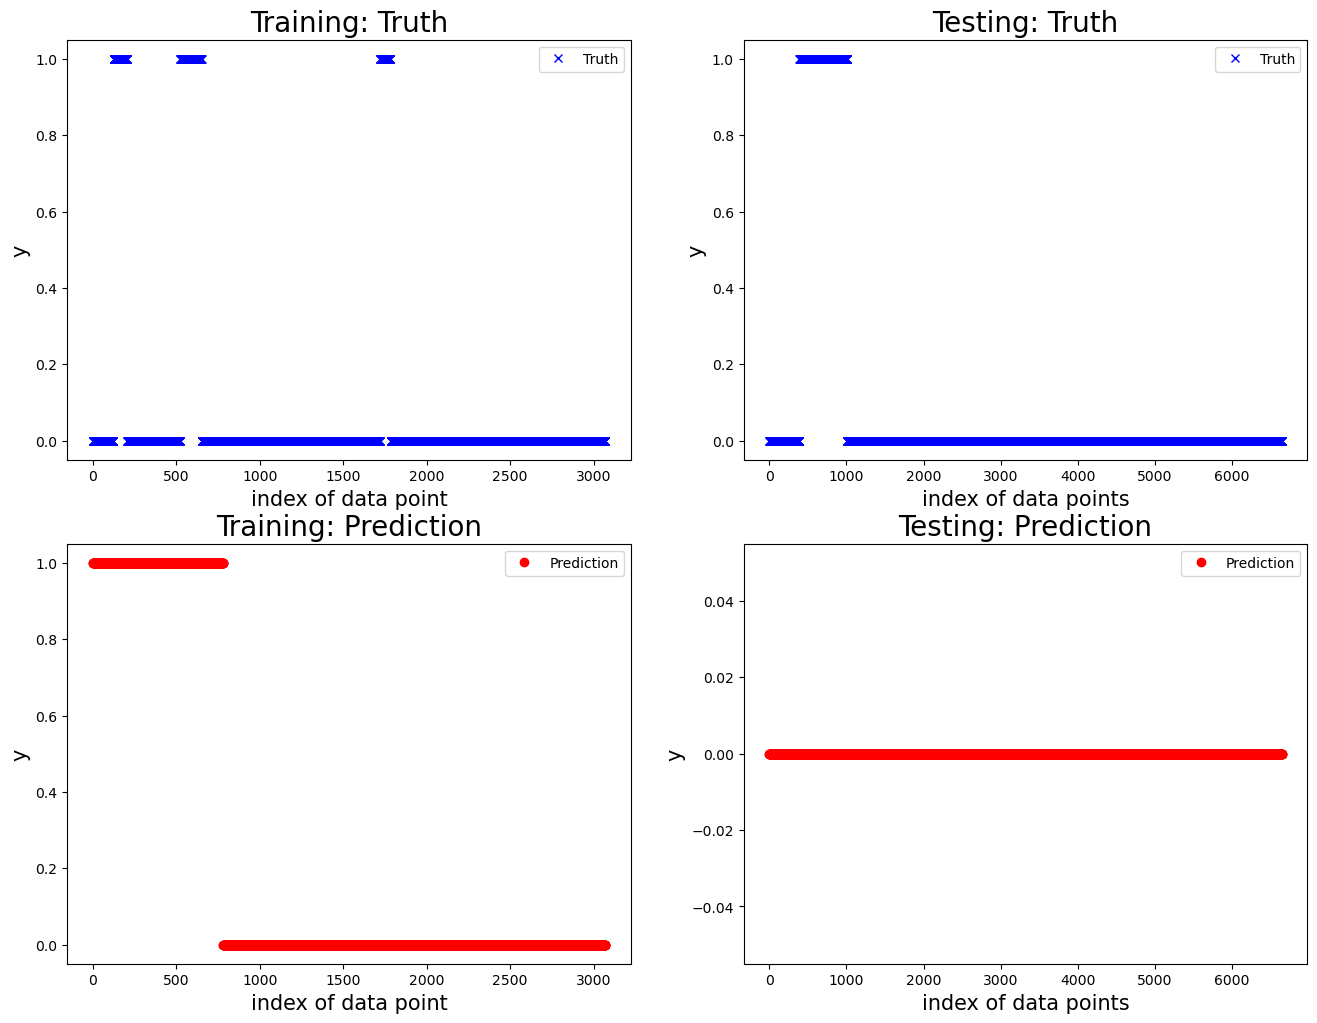


 New cv run:

Training performance, accuracy is: 0.8412514484356894
Training performance, precision is: 0.34095063985374774
Training performance, recall: 0.9198520345252774
Training performance, F1: 0.49749916638879627


Prediction performance, accuracy is: 0.36283185840707965
Prediction performance, precision is: 0.36283185840707965
Prediction performance, recall is：1.0
Prediction performance, F1 is：0.5324675324675325


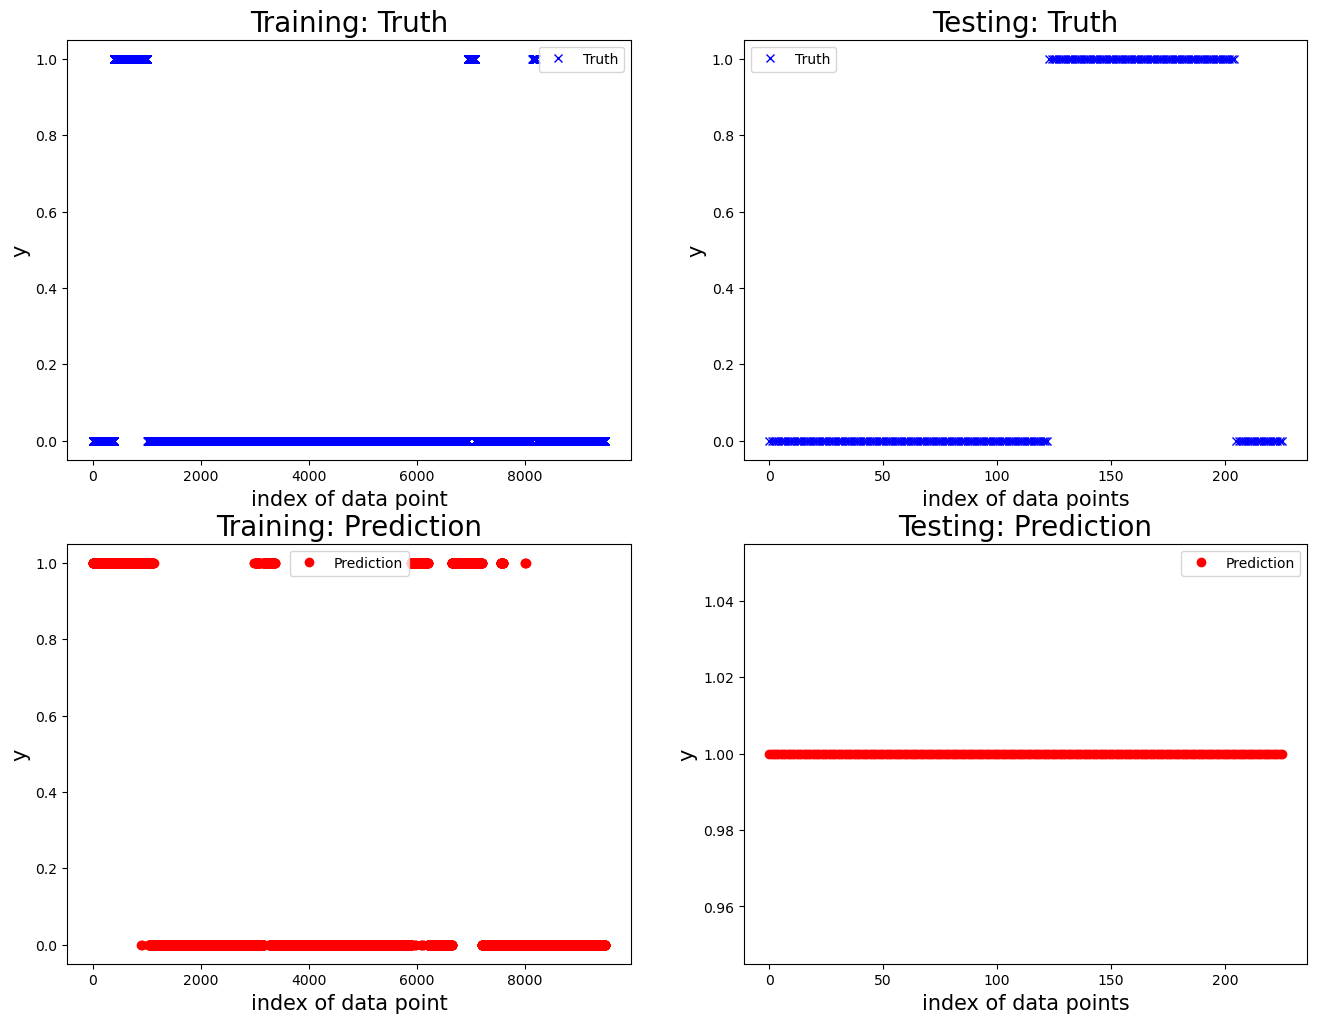


 New cv run:

Training performance, accuracy is: 0.9702095154954169
Training performance, precision is: 0.7517948717948718
Training performance, recall: 0.9594240837696335
Training performance, F1: 0.8430132259919493


Prediction performance, accuracy is: 0.8594594594594595
Prediction performance, precision is: 1.0
Prediction performance, recall is：0.3953488372093023
Prediction performance, F1 is：0.5666666666666667


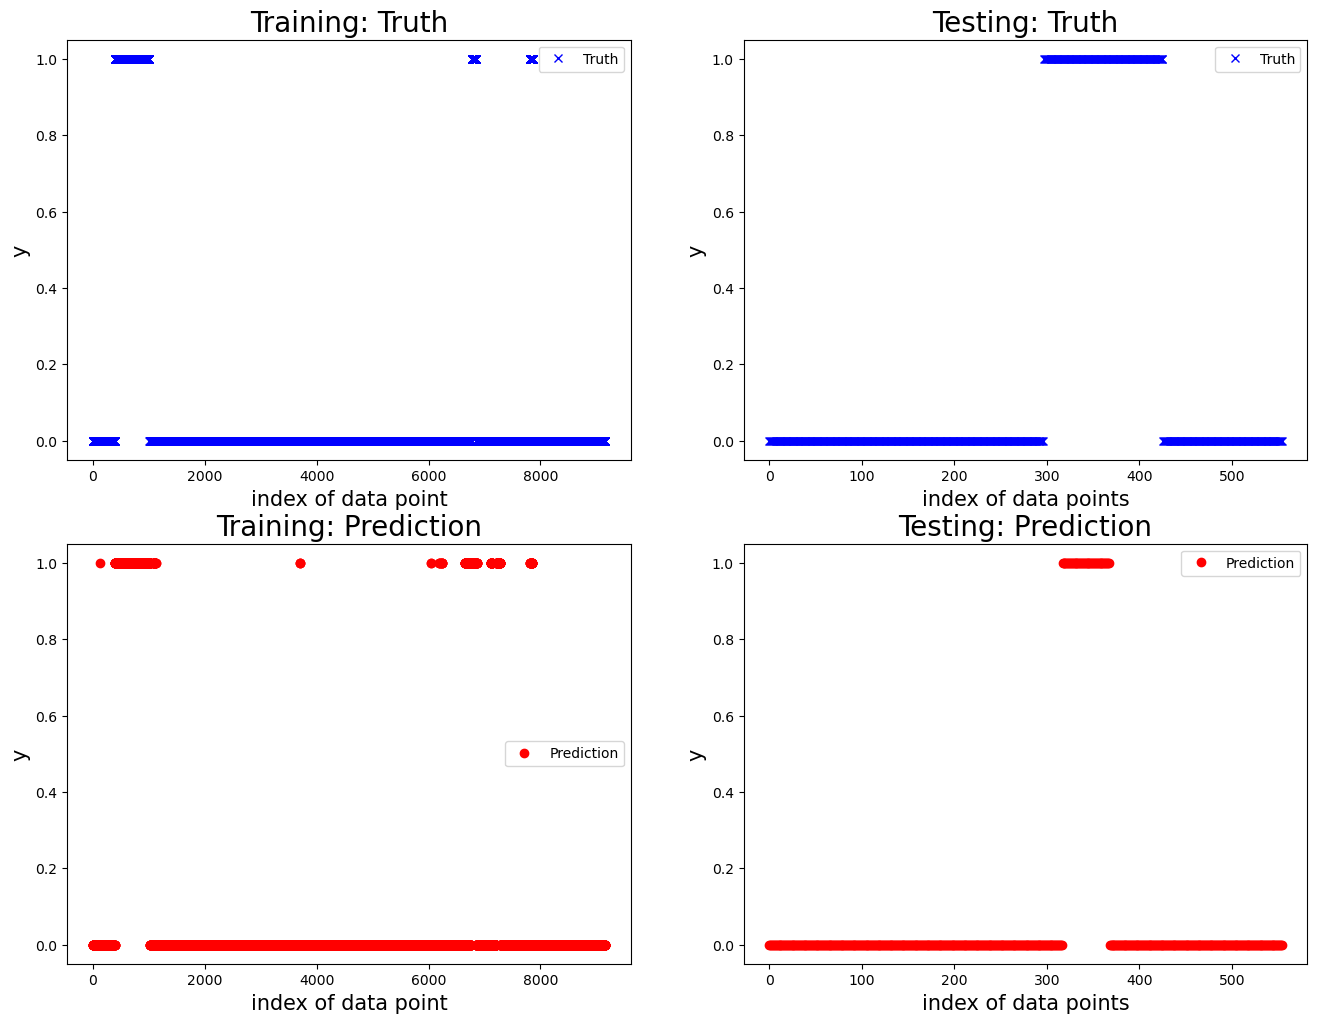


 New cv run:

Training performance, accuracy is: 0.8460829493087557
Training performance, precision is: 0.3827618164967563
Training performance, recall: 0.9951807228915662
Training performance, F1: 0.5528781793842036


Prediction performance, accuracy is: 0.9018286814244466
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


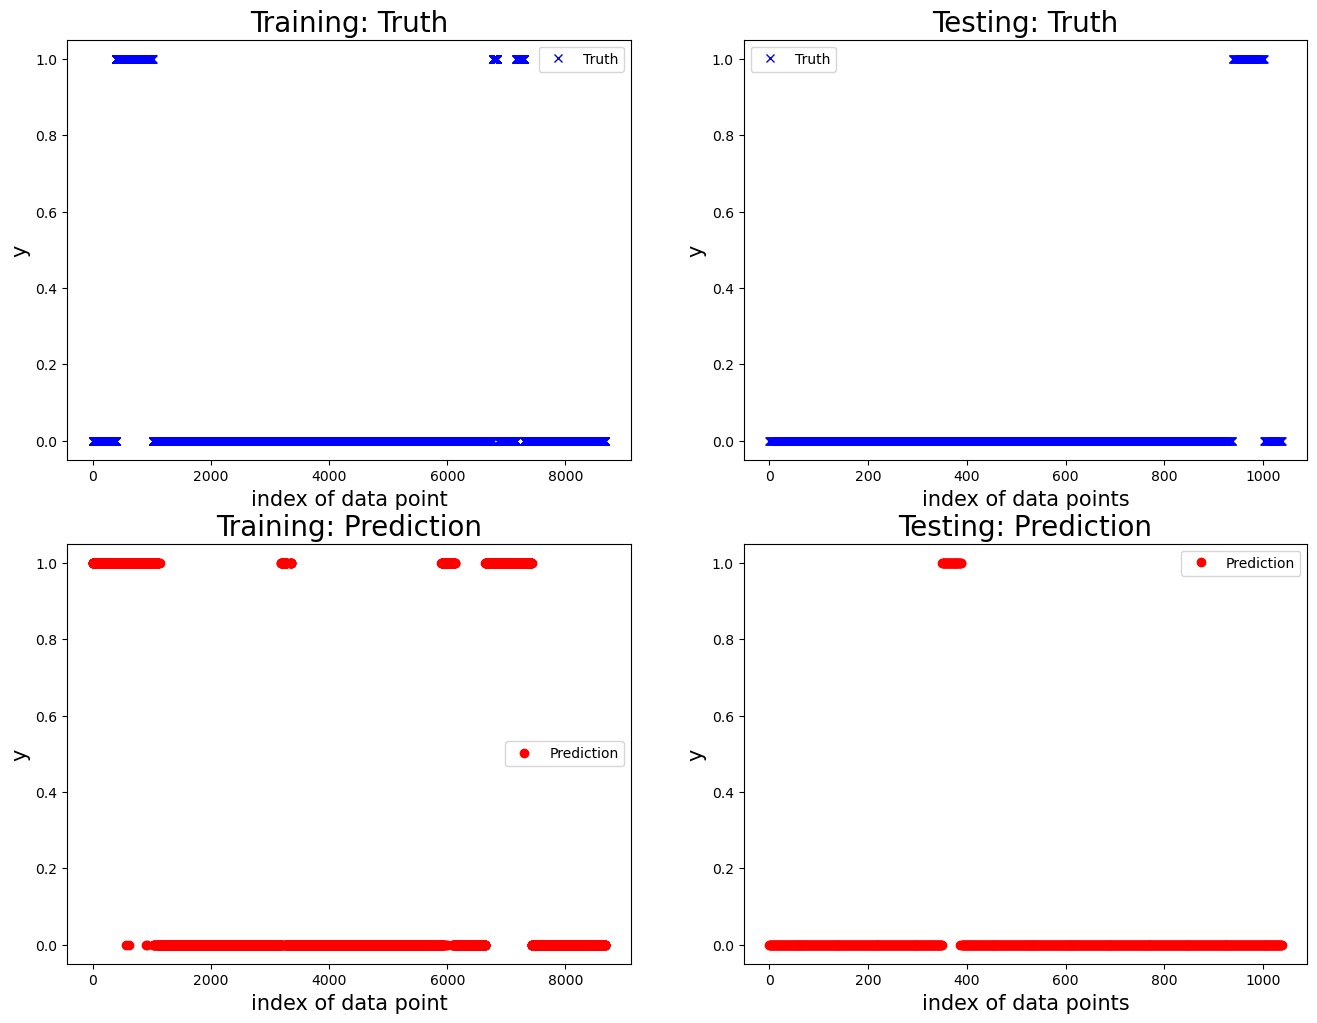


 New cv run:

Training performance, accuracy is: 0.9311444431321602
Training performance, precision is: 0.6154992548435171
Training performance, recall: 0.9249720044792833
Training performance, F1: 0.7391498881431767


Prediction performance, accuracy is: 1.0
Prediction performance, precision is: 1.0
Prediction performance, recall is：1.0
Prediction performance, F1 is：1.0


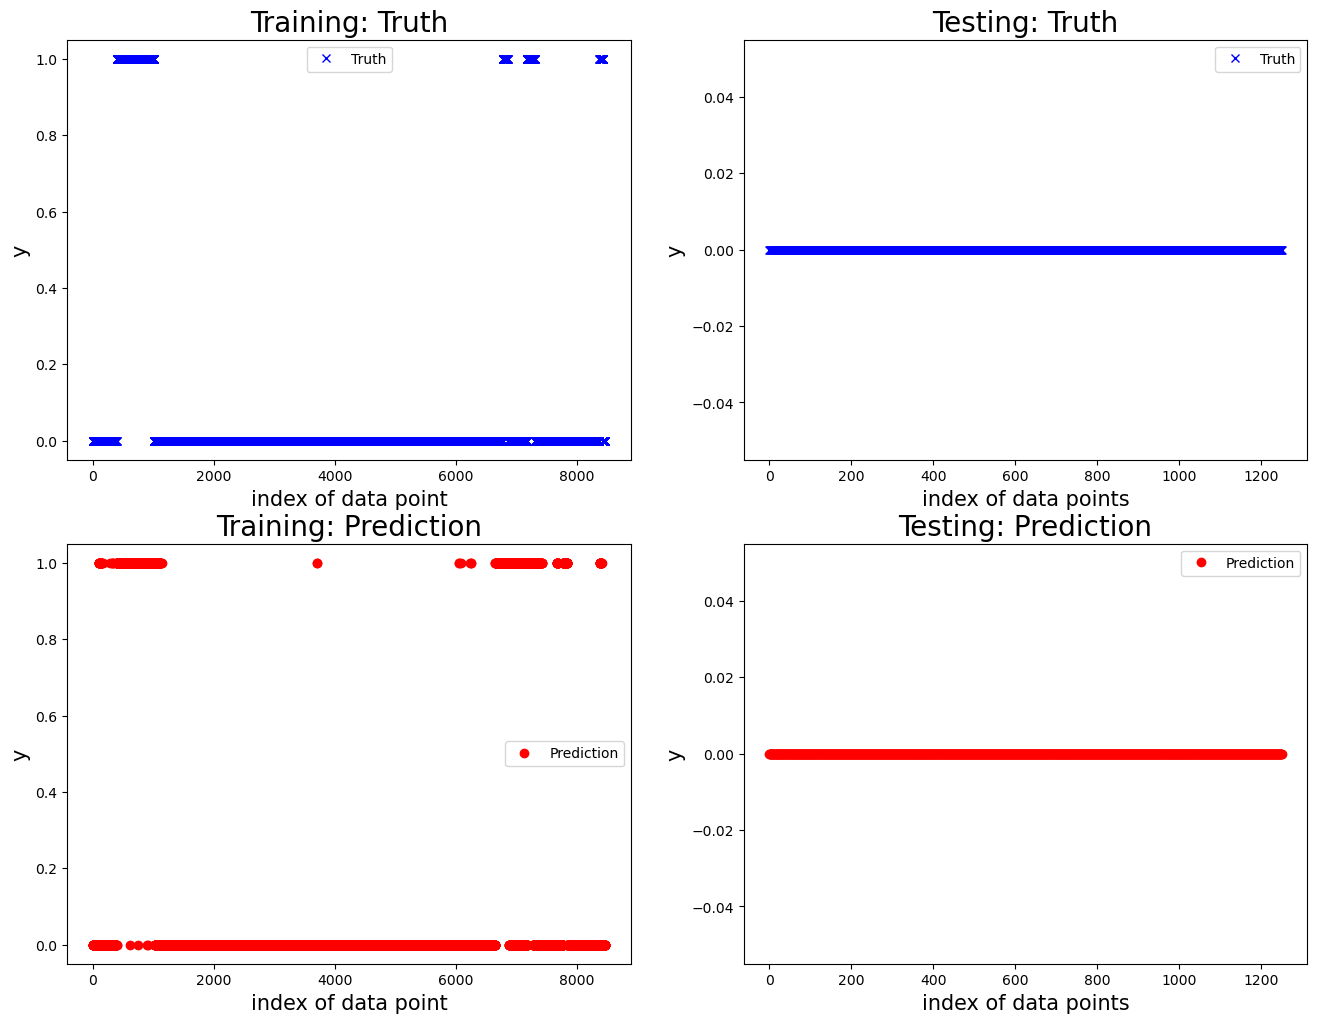

Accuracy     0.806199
Precision    0.472566
Recall       0.479070
F1 score     0.419827
dtype: float64




In [12]:
# all_results = run_all_motors(df_data, grid_search, window_size=5, single_run_result=False, mdl_type='clf')
all_results = run_one_motor_detection(6, df_data, grid_search, window_size=5, single_run_result=True, mdl_type='clf')

### window size = 10

Model for predicting the label of motor 6:

 New cv run:

Training performance, accuracy is: 0.7958715596330275
Training performance, precision is: 0.27367055771725035
Training performance, recall: 0.7700729927007299
Training performance, F1: 0.4038277511961723


Prediction performance, accuracy is: 0.9068051791629027
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


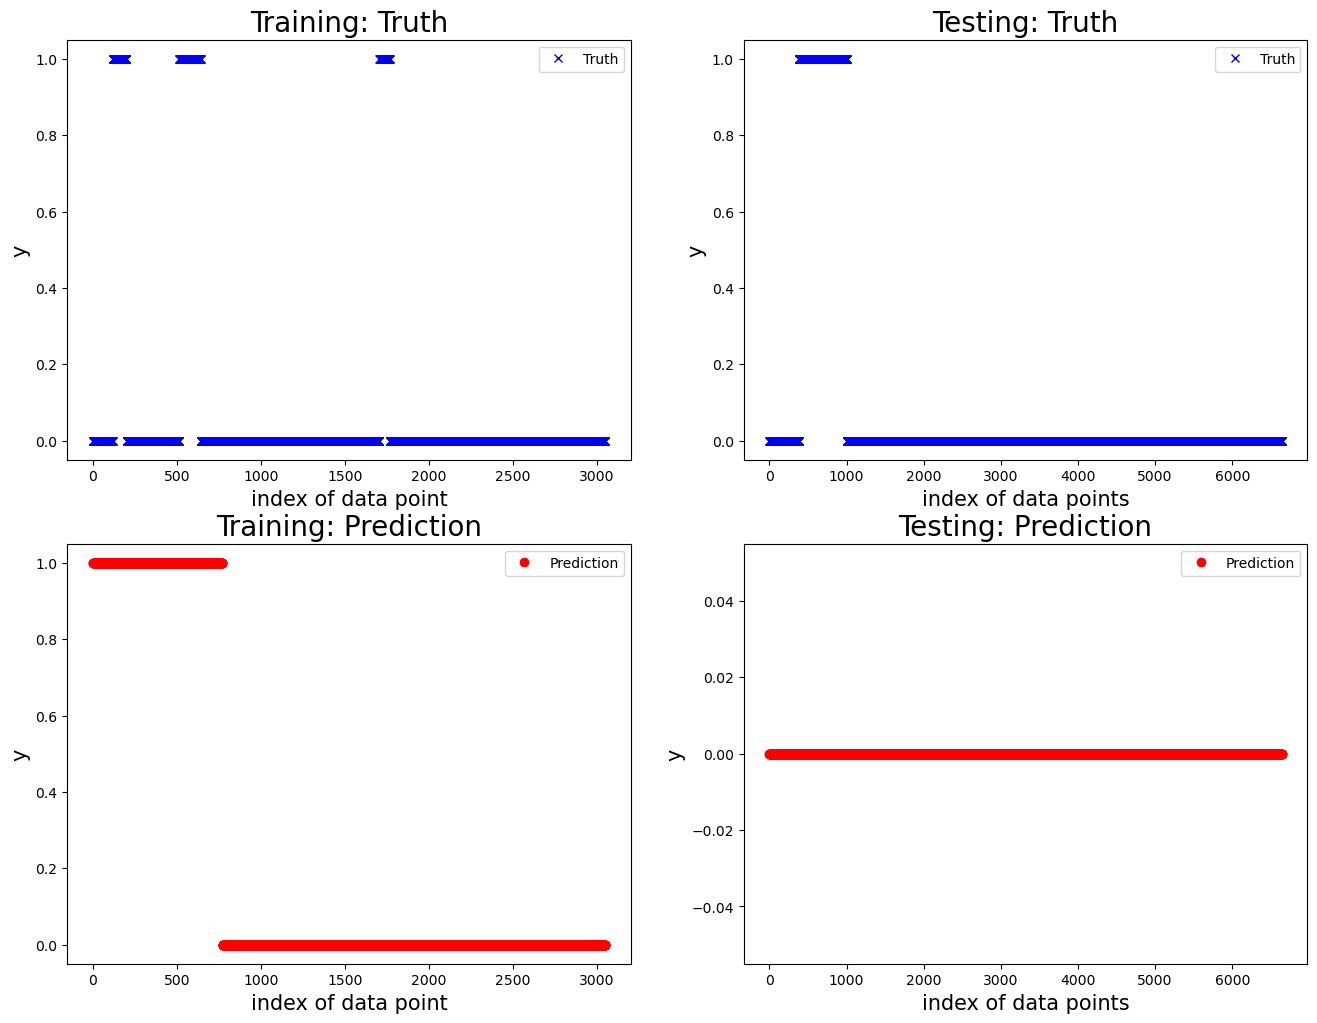


 New cv run:

Training performance, accuracy is: 0.8421830465533622
Training performance, precision is: 0.3428308823529412
Training performance, recall: 0.9198520345252774
Training performance, F1: 0.49949782390358227


Prediction performance, accuracy is: 0.37104072398190047
Prediction performance, precision is: 0.37104072398190047
Prediction performance, recall is：1.0
Prediction performance, F1 is：0.5412541254125413


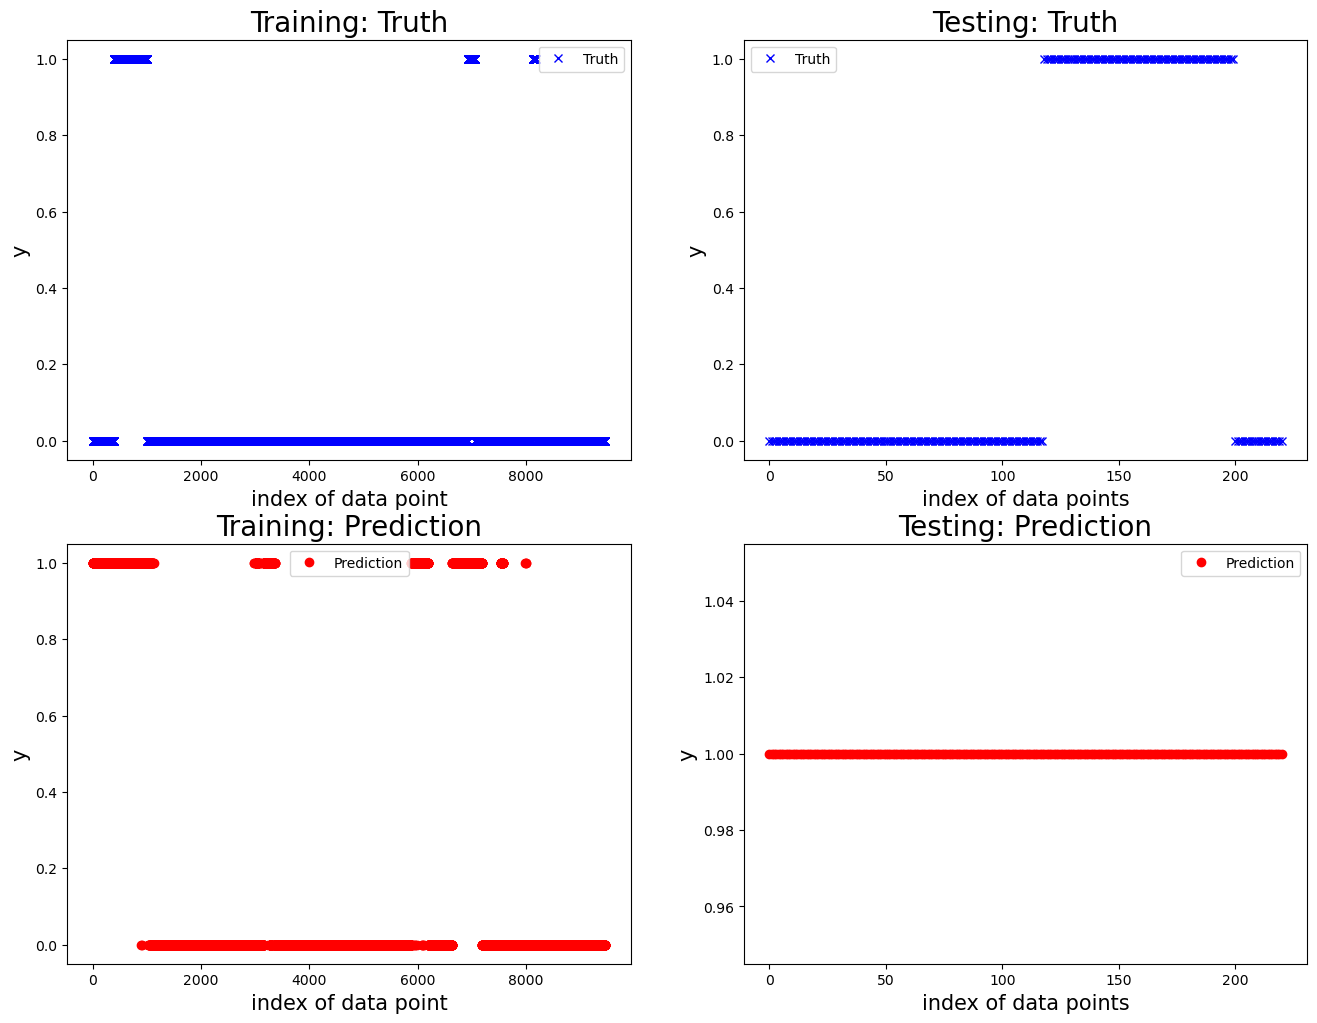


 New cv run:

Training performance, accuracy is: 0.9698162729658792
Training performance, precision is: 0.7494887525562373
Training performance, recall: 0.9594240837696335
Training performance, F1: 0.8415614236509759


Prediction performance, accuracy is: 0.8581818181818182
Prediction performance, precision is: 1.0
Prediction performance, recall is：0.3953488372093023
Prediction performance, F1 is：0.5666666666666667


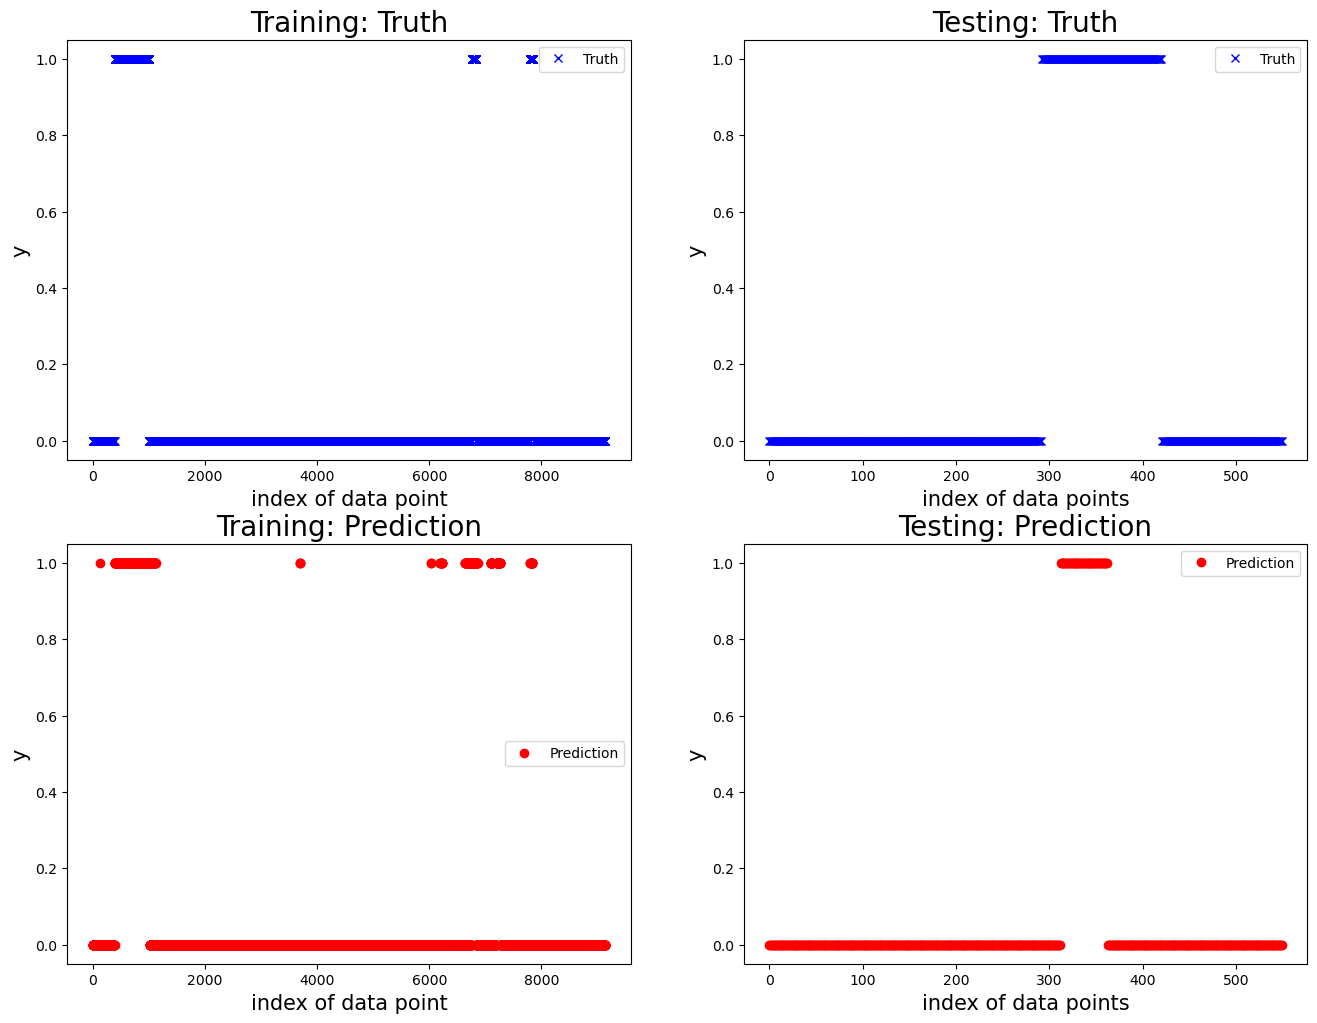


 New cv run:

Training performance, accuracy is: 0.8475750577367206
Training performance, precision is: 0.38562091503267976
Training performance, recall: 0.9951807228915662
Training performance, F1: 0.5558546433378196


Prediction performance, accuracy is: 0.9013539651837524
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


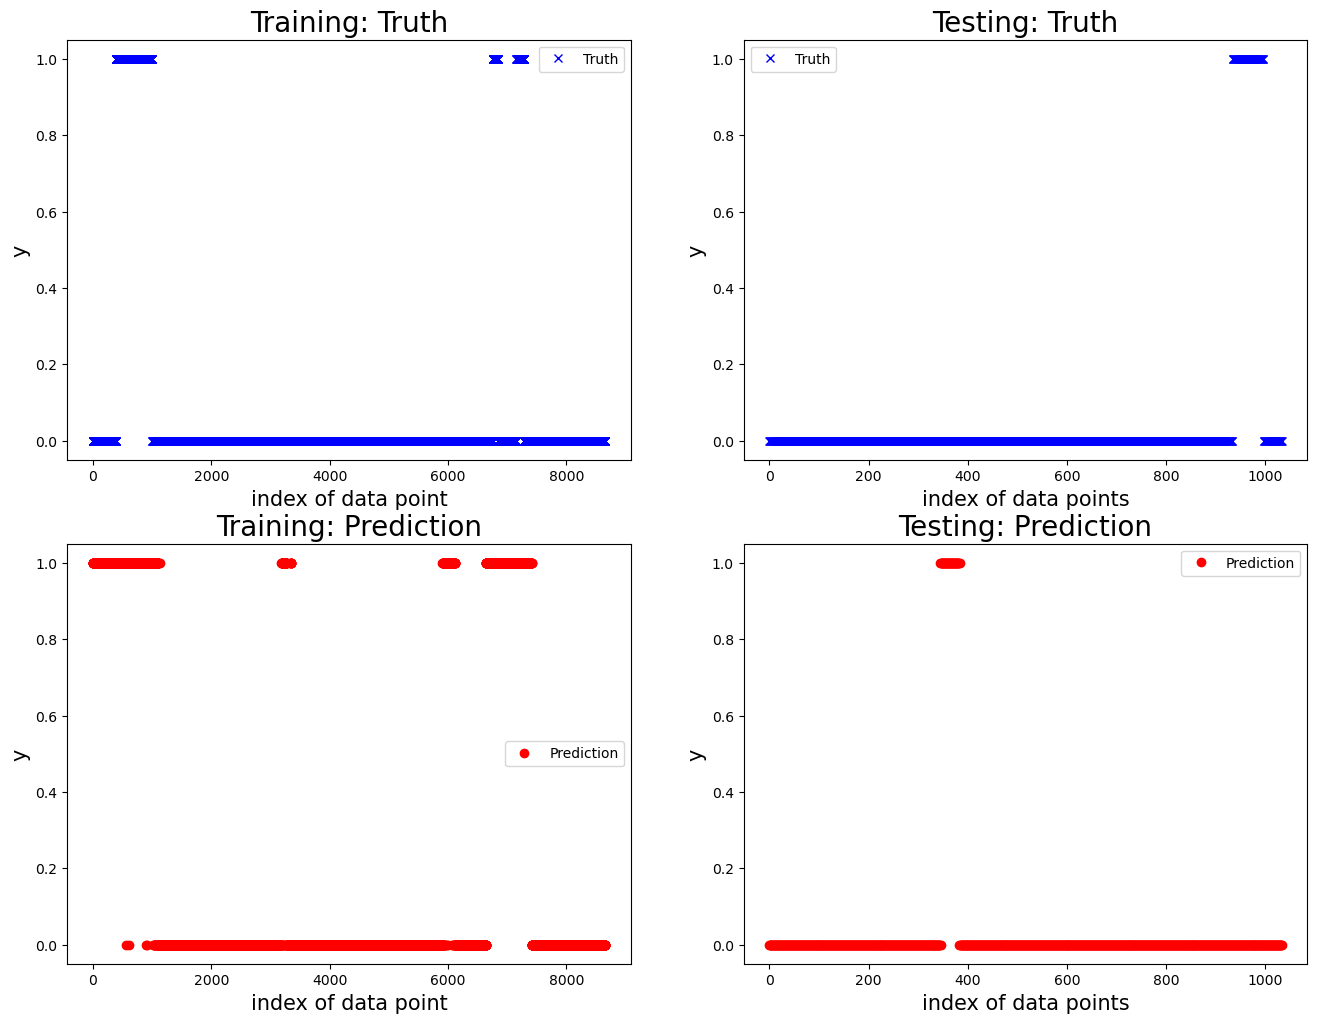


 New cv run:

Training performance, accuracy is: 0.9296791760388303
Training performance, precision is: 0.6101694915254238
Training performance, recall: 0.9272116461366181
Training performance, F1: 0.736


Prediction performance, accuracy is: 1.0
Prediction performance, precision is: 1.0
Prediction performance, recall is：1.0
Prediction performance, F1 is：1.0


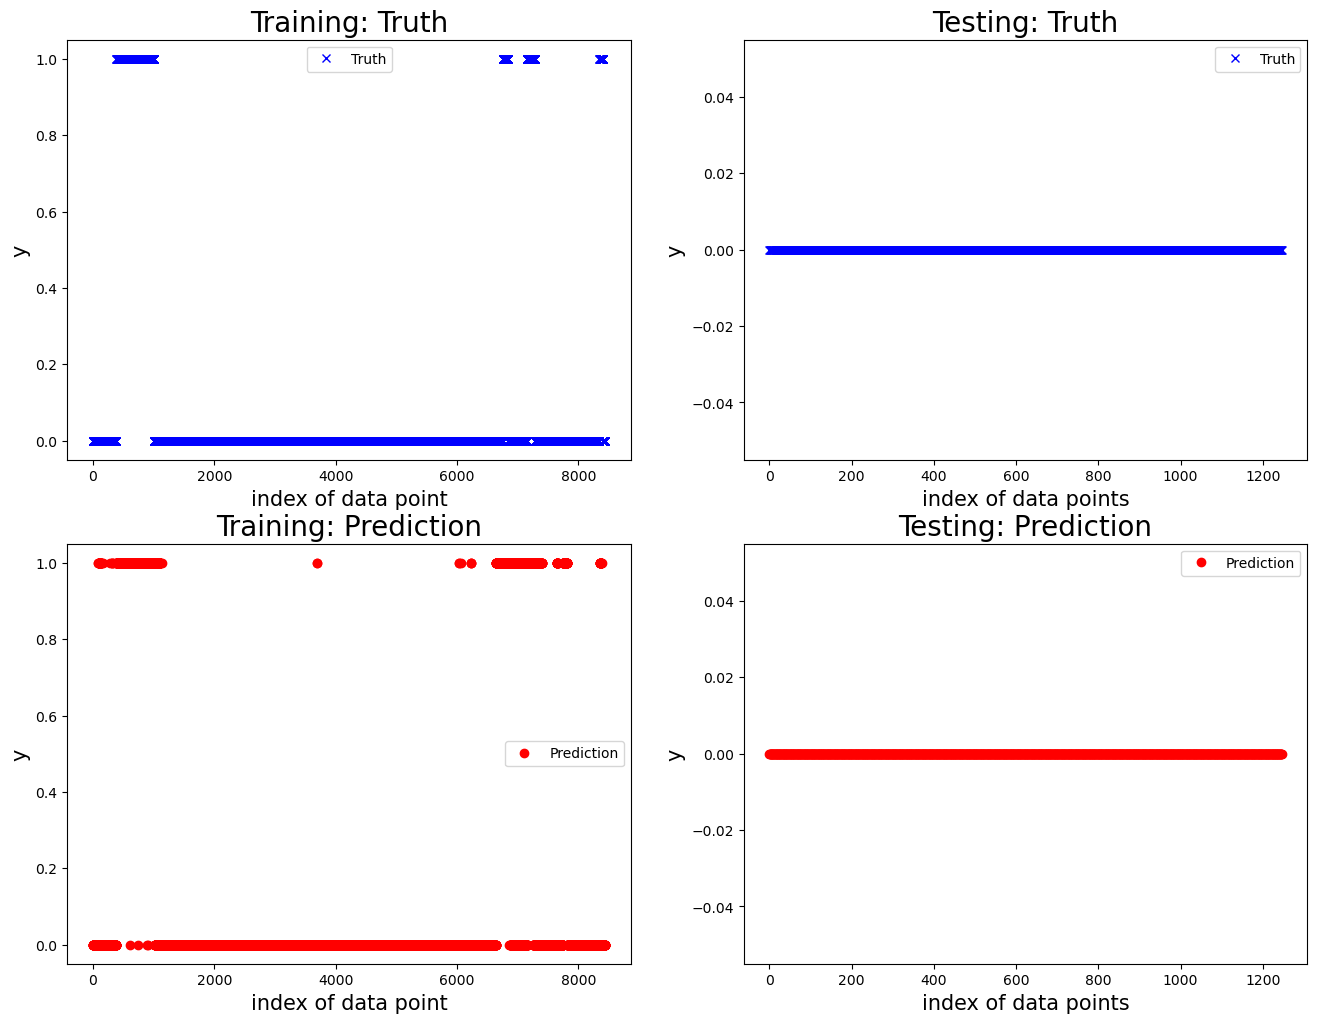

Accuracy     0.807476
Precision    0.474208
Recall       0.479070
F1 score     0.421584
dtype: float64




In [13]:
# all_results = run_all_motors(df_data, grid_search, window_size=10, single_run_result=False, mdl_type='clf')
all_results = run_one_motor_detection(6, df_data, grid_search, window_size=10, single_run_result=True, mdl_type='clf')

Model for predicting the label of motor 6:

 New cv run:

Training performance, accuracy is: 0.799800796812749
Training performance, precision is: 0.2809587217043941
Training performance, recall: 0.7700729927007299
Training performance, F1: 0.4117073170731707


Prediction performance, accuracy is: 0.906664656212304
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


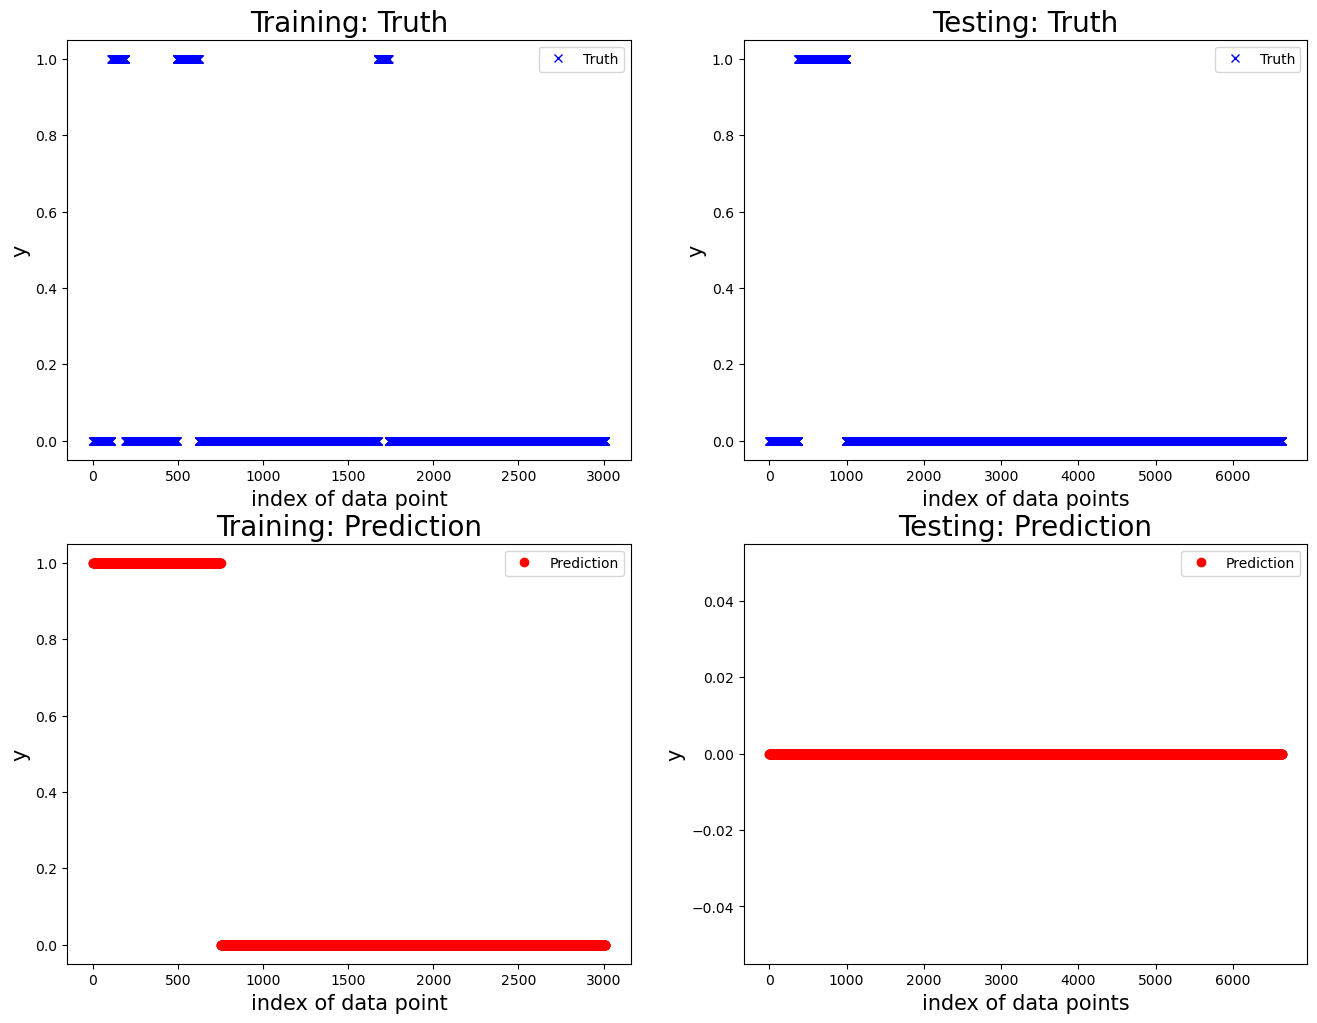


 New cv run:

Training performance, accuracy is: 0.8436340506731687
Training performance, precision is: 0.3460111317254174
Training performance, recall: 0.9198520345252774
Training performance, F1: 0.5028648466464442


Prediction performance, accuracy is: 0.3886255924170616
Prediction performance, precision is: 0.3886255924170616
Prediction performance, recall is：1.0
Prediction performance, F1 is：0.5597269624573379


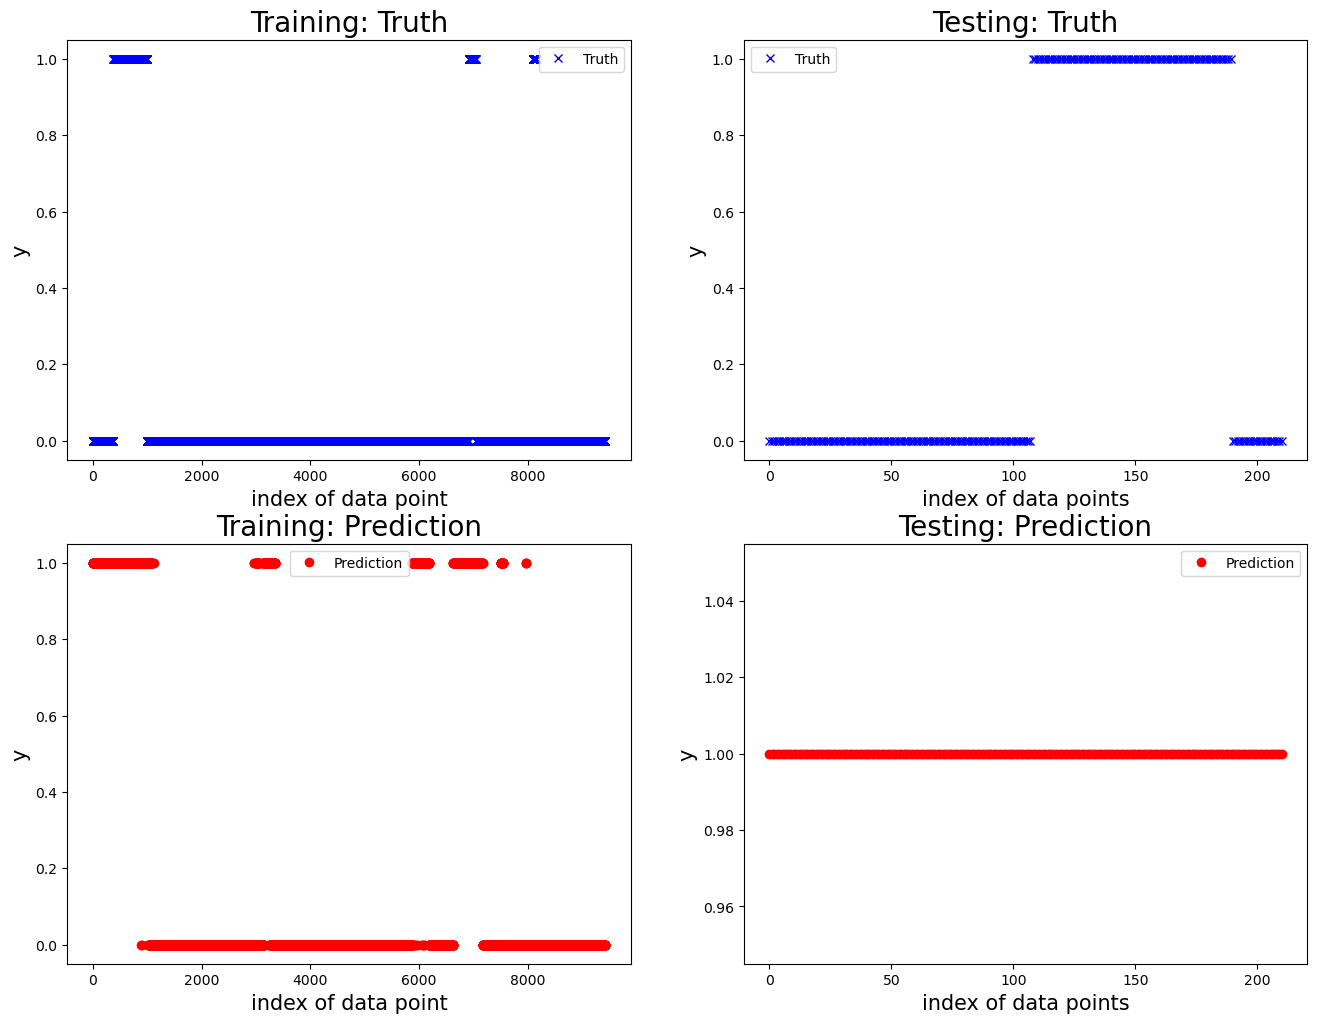


 New cv run:

Training performance, accuracy is: 0.968695079086116
Training performance, precision is: 0.7421638018200202
Training performance, recall: 0.9607329842931938
Training performance, F1: 0.8374215630347973


Prediction performance, accuracy is: 0.8555555555555555
Prediction performance, precision is: 1.0
Prediction performance, recall is：0.3953488372093023
Prediction performance, F1 is：0.5666666666666667


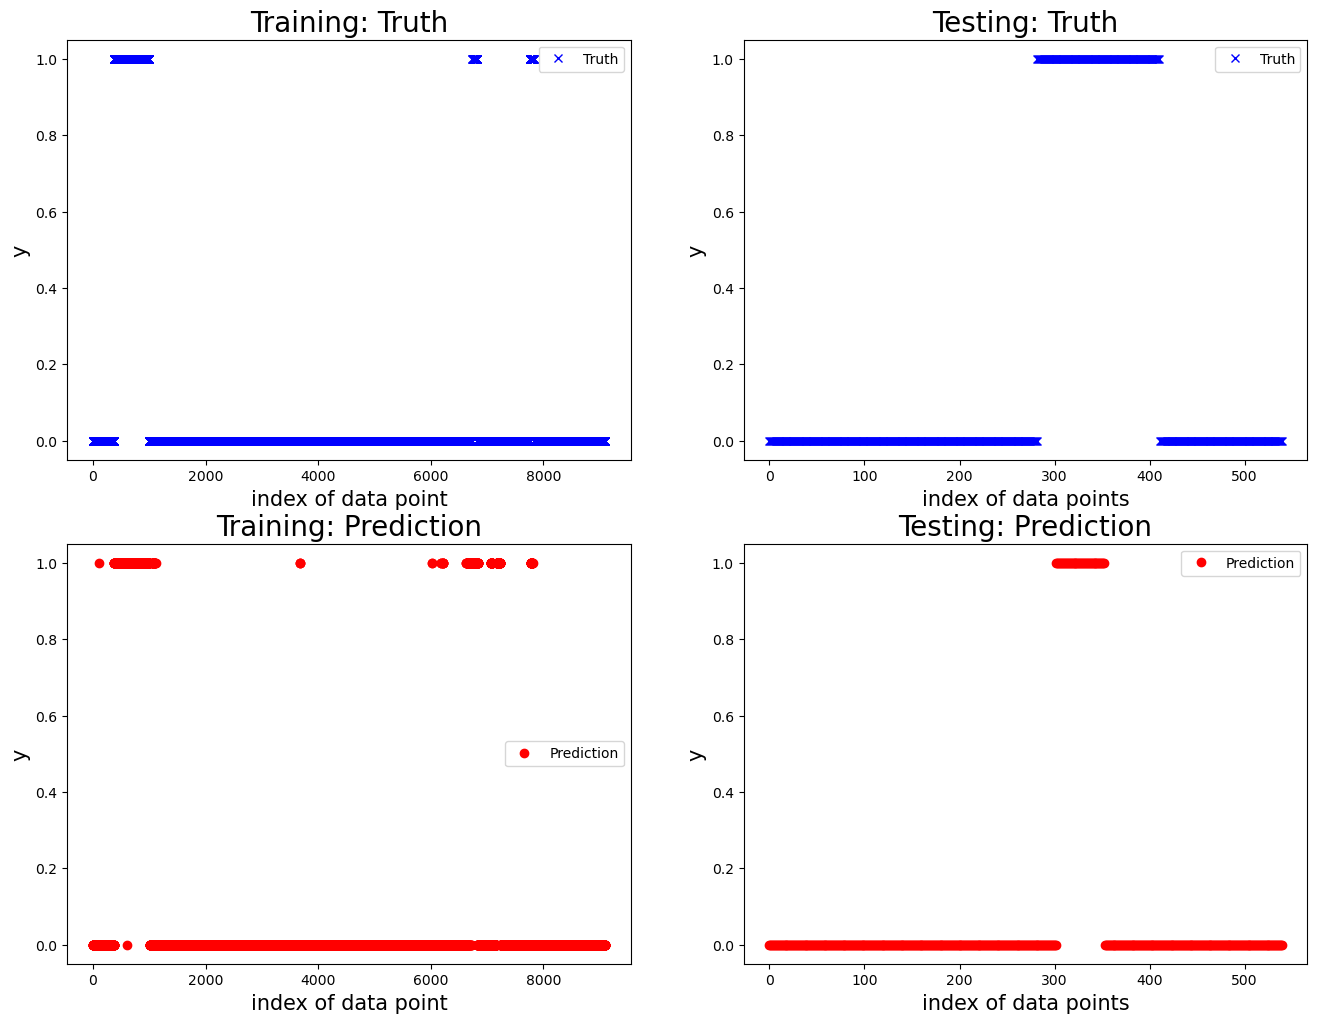


 New cv run:

Training performance, accuracy is: 0.8504640371229698
Training performance, precision is: 0.3912837517764093
Training performance, recall: 0.9951807228915662
Training performance, F1: 0.5617137028221694


Prediction performance, accuracy is: 0.900390625
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


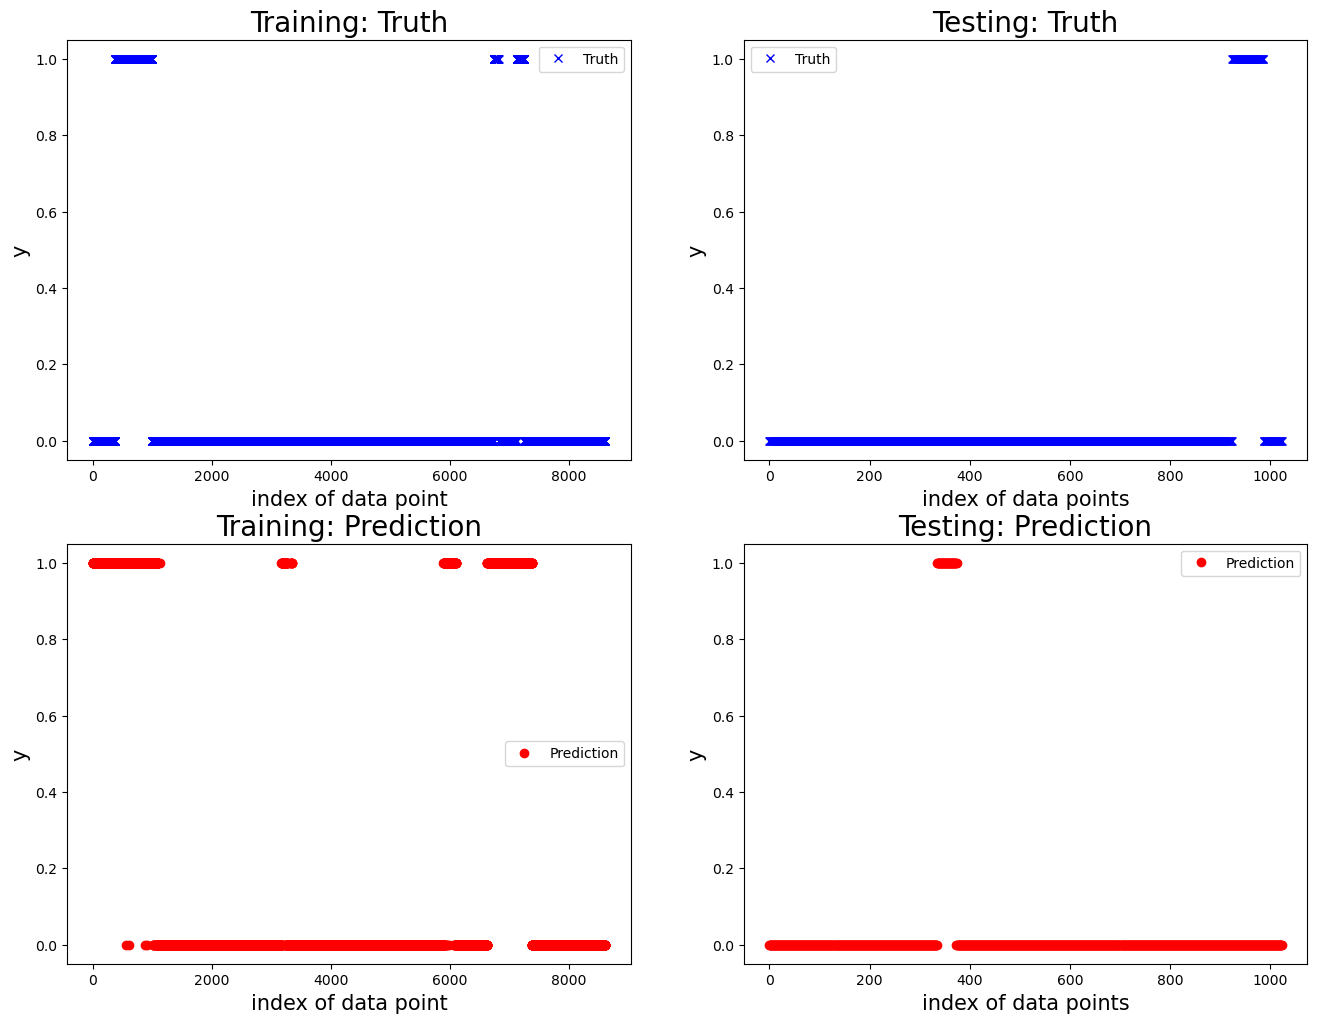


 New cv run:

Training performance, accuracy is: 0.9494468894968479
Training performance, precision is: 0.6973018549747049
Training performance, recall: 0.9260918253079508
Training performance, F1: 0.7955747955747956


Prediction performance, accuracy is: 0.9991915925626516
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


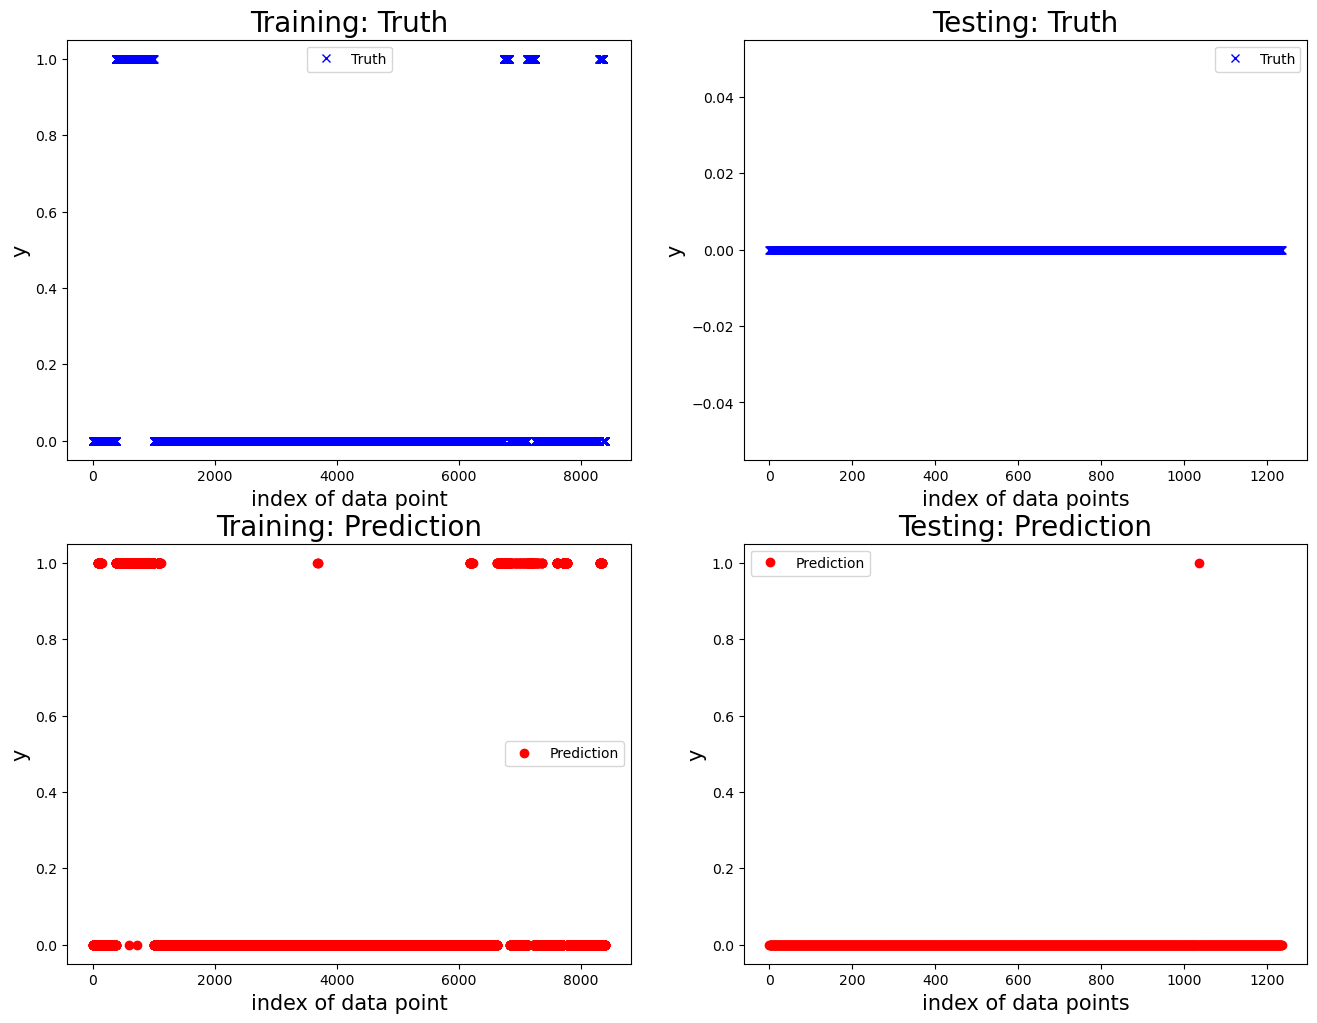

Accuracy     0.810086
Precision    0.277725
Recall       0.279070
F1 score     0.225279
dtype: float64




In [14]:
# all_results = run_all_motors(df_data, grid_search, window_size=20, single_run_result=False, mdl_type='clf')
all_results = run_one_motor_detection(6, df_data, grid_search, window_size=20, single_run_result=True, mdl_type='clf')